In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.2.2 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
print "creating train and macro table"
train = pd.read_csv("train.csv")
macro = pd.read_csv("macro.csv")
print "train shape: ", train.shape
print "macro shape: ",macro.shape

creating train and macro table
train shape:  (30471, 292)
macro shape:  (2484, 100)


(-100000, 40000000)

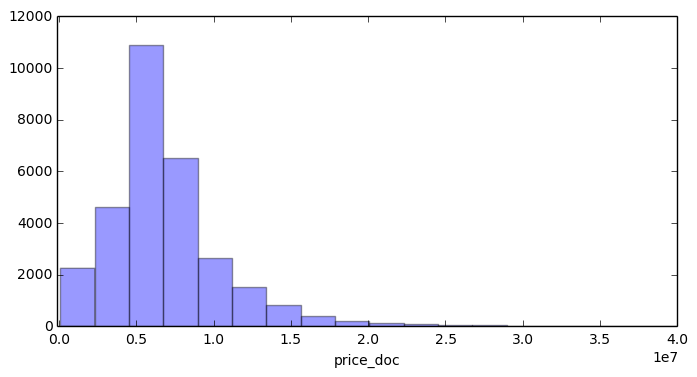

In [16]:
# price distribution
plt.figure(figsize=(8,4))
sns.distplot(train.price_doc,kde=False)
plt.xlim(-100000,40000000)

In [20]:
#Missing Data
#How much data is missing?

missing values in %
num of columns contain missing values:  51


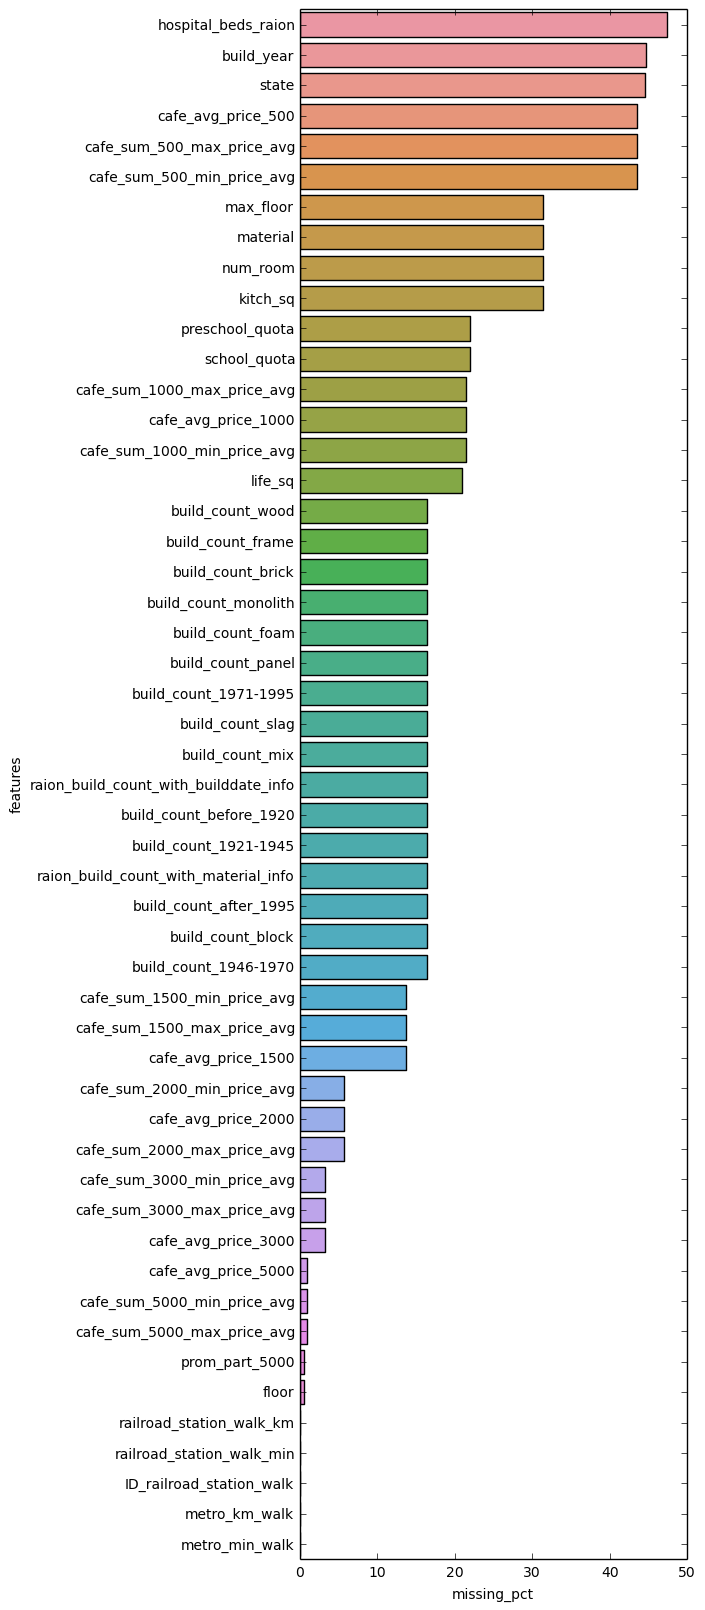

In [62]:
print "missing values in %"
print "num of columns contain missing values: ", train.isnull().any().sum()
plt.figure(figsize=(5,20))
x = (train.isnull().sum(axis=0)/len(train)*100).to_frame().reset_index().rename(columns={'index':'features',0:"missing_pct"}).sort_values(['missing_pct'],ascending=False)
x_ = x[x['missing_pct']>0]
sns.barplot(x_.missing_pct,x_.features)

In [108]:
# minor entry errors in the dataset
print "unique values"
cols = train.columns.values
for c in cols:
    print c, str(len(train[c].unique()))

unique values
id 30471
timestamp 1161
full_sq 211
life_sq 176
floor 42
max_floor 50
material 7
build_year 119
num_room 14
kitch_sq 75
state 5
product_type 2
sub_area 146
area_m 146
raion_popul 146
green_zone_part 146
indust_part 132
children_preschool 146
preschool_quota 122
preschool_education_centers_raion 13
children_school 146
school_quota 126
school_education_centers_raion 14
school_education_centers_top_20_raion 3
hospital_beds_raion 80
healthcare_centers_raion 7
university_top_20_raion 4
sport_objects_raion 24
additional_education_raion 12
culture_objects_top_25 2
culture_objects_top_25_raion 6
shopping_centers_raion 16
office_raion 30
thermal_power_plant_raion 2
incineration_raion 2
oil_chemistry_raion 2
radiation_raion 2
railroad_terminal_raion 2
big_market_raion 2
nuclear_reactor_raion 2
detention_facility_raion 2
full_all 146
male_f 146
female_f 146
young_all 146
young_male 145
young_female 145
work_all 145
work_male 145
work_female 146
ekder_all 146
ekder_male 146
ekder_fem

In [94]:
from scipy.stats import mode
# state should be discrete valued between 1 and 4. There is a 33 in it that is cleary a data entry error
# Lets just replace it with the mode.
train['state'] = train['state'].replace(33.0,mode(train.state)[0][0])
# build_year has an erronus value 20052009. Since its unclear which it should be, let's replace with 2007
train['build_year'] = train['build_year'].replace(20052009.0,2007.0)

## Housing Internal Characteristics

In [101]:
#Housing Characteristics
#Let’s look for correlation among the internal home characteristics and price.
cols = ['full_sq', 'life_sq', 'floor', 'max_floor','material', 'build_year', 'num_room', 
        'kitch_sq', 'state', 'product_type',"sub_area",'price_doc']

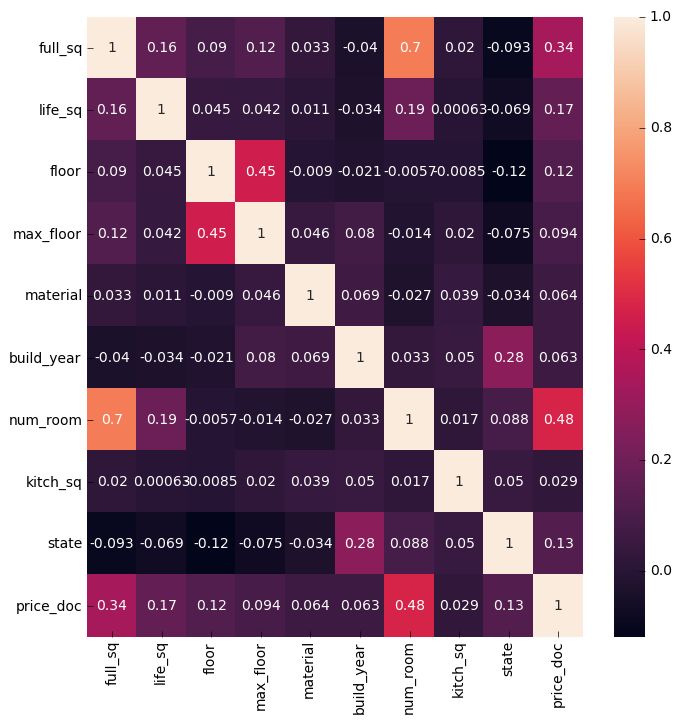

In [107]:
corr = train[cols].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr,annot=True)

In [109]:
#Area of Home and Number of Rooms

#We saw earlier that full_sq is correlated with price. Let’s take a closer look.

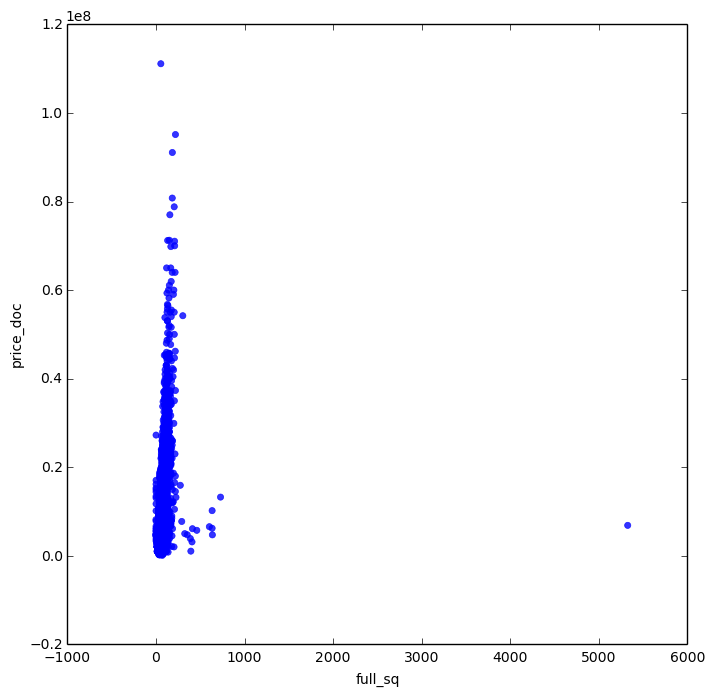

In [126]:
plt.figure(figsize=(8,8))
sns.regplot(train['full_sq'],train['price_doc'],fit_reg=False)

In [127]:
#remove outlier (big and cheap)
train[train['full_sq']>5000]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
3527,3530,2012-09-07,5326,22.0,13.0,NaN,NaN,NaN,NaN,NaN,...,7,2,0,5,16,0,2,43,6,6868818


In [132]:
train.drop([3527],inplace=True)

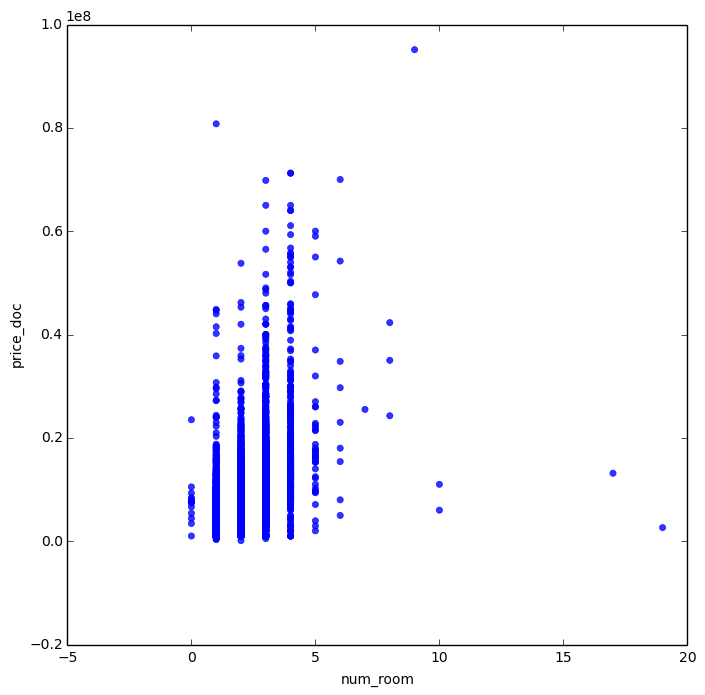

In [122]:
plt.figure(figsize=(8,8))
sns.regplot(train['num_room'],train['price_doc'],fit_reg=False)

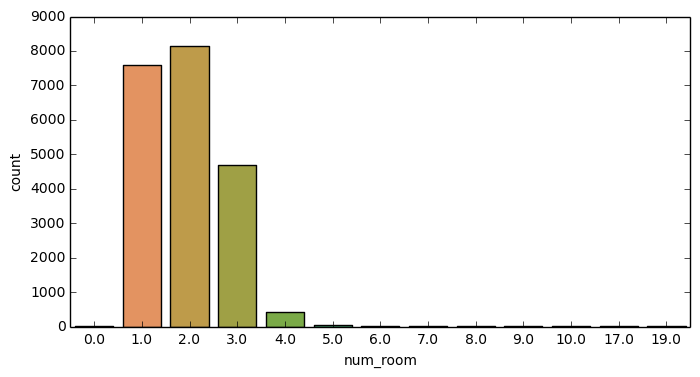

In [125]:
plt.figure(figsize=(8,4))
sns.countplot(train['num_room'])

In [ ]:
#life_sq is always less than full_sq.

In [144]:
train.drop(train[train['full_sq']<train['life_sq']].index,inplace=True)

In [ ]:
#Sale Type

#Is there a significant difference in price for homes bought by an owner-occupier or homes bought for investment?

In [145]:
train.product_type.value_counts()

Investment       19430
OwnerOccupier    11003
Name: product_type, dtype: int64

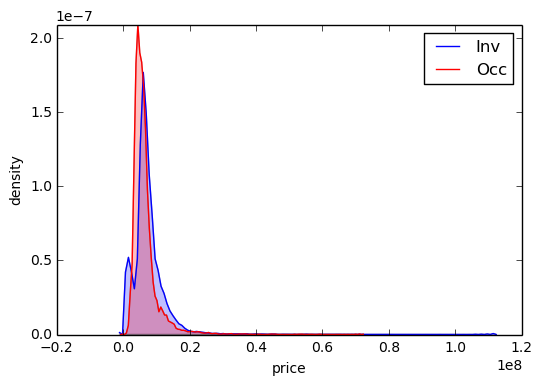

In [205]:
plt.xlabel("price")
plt.ylabel("density")
plt.xlim(0,)
sns.kdeplot(train[train['product_type']=='Investment']['price_doc'],shade=True,label="Inv")
sns.kdeplot(train[train['product_type']=='OwnerOccupier']['price_doc'],shade=True,color='red',label="Occ")

In [206]:
train.product_type.value_counts()

Investment       19430
OwnerOccupier    11003
Name: product_type, dtype: int64

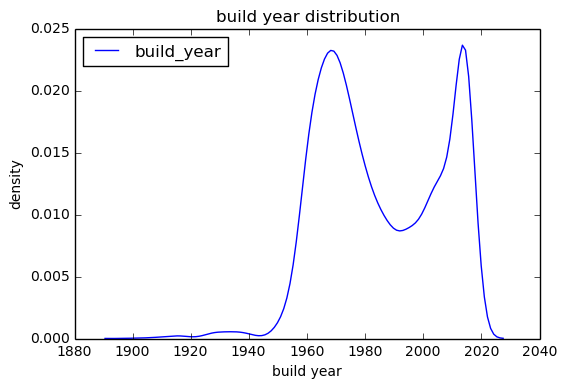

In [221]:
# build_year distribution
plt.title("build year distribution")
plt.xlabel("build year")
plt.ylabel("density")
sns.kdeplot(train[train['build_year'].between(1900,2018)]['build_year'])


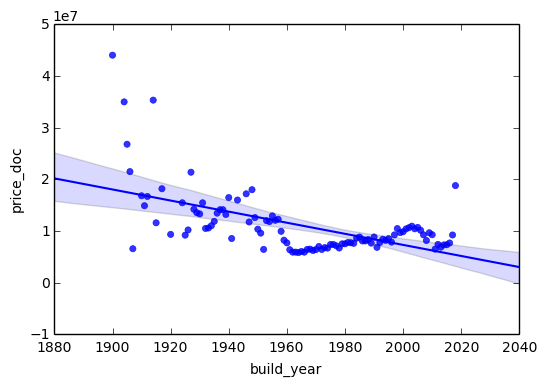

In [240]:
# build year and mean_price
x = train.groupby(['build_year'],as_index=False)['price_doc'].mean()
sns.regplot(x[x['build_year'].between(1900,2018)]['build_year'],x[x['build_year'].between(1900,2018)]['price_doc'])

In [283]:
### set bad build years to nan
#train['build_year'].value_counts().reset_index().sort_values(['index'])
bad_years = [0.0,1.0,3.0,20.0,71.0,215.0,1691.0,4965.0]
for y in bad_years:
    train.loc[train['build_year']==y,'build_year']=np.nan

In [ ]:
#sale price over month

train['timestamp'] = pd.to_datetime(train['timestamp'])
train['year'] = train['timestamp'].dt.year
train['month'] = train['timestamp'].dt.month
train['day'] = train['timestamp'].dt.day

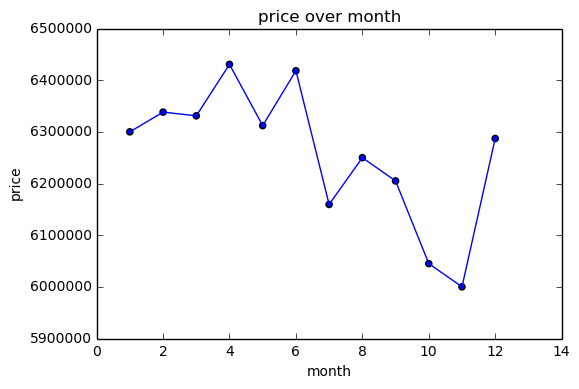

In [301]:
x = train.groupby(['month'],as_index=False)['price_doc'].median()
plt.plot(x['month'],x['price_doc'])
plt.scatter(x['month'],x['price_doc'])
plt.xlabel("month")
plt.ylabel("price")
plt.title("price over month")

In [303]:
# price over state
train.state.value_counts()

2.0    5842
3.0    5785
1.0    4839
4.0     422
Name: state, dtype: int64

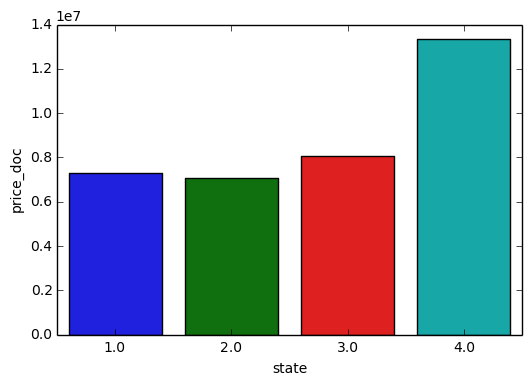

In [311]:
x = train.groupby(['state'],as_index=False)['price_doc'].mean()
sns.barplot(x.state,x.price_doc)

In [309]:
# price over material
train.material.value_counts()

1.0    14177
2.0     2991
5.0     1560
4.0     1342
6.0      803
3.0        1
Name: material, dtype: int64

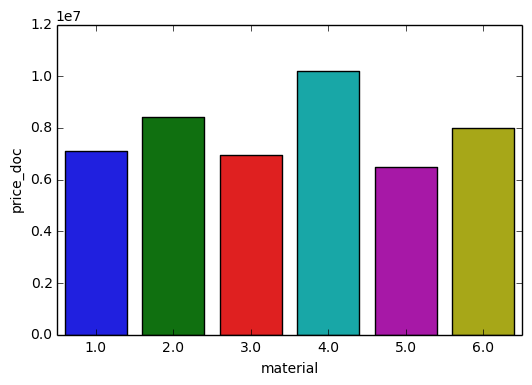

In [312]:
x = train.groupby(['material'],as_index=False)['price_doc'].mean()
sns.barplot(x.material,x.price_doc)

In [314]:
#price over floor
train.floor.value_counts()

3.0     3024
2.0     2872
5.0     2745
4.0     2605
1.0     2001
7.0     1966
6.0     1877
9.0     1841
8.0     1828
12.0    1338
10.0    1304
11.0    1260
14.0    1001
13.0     916
16.0     811
17.0     793
15.0     746
18.0     231
19.0     212
20.0     180
22.0     172
21.0     138
23.0     125
25.0     104
24.0     100
32.0      14
26.0      14
0.0        9
27.0       7
28.0       6
30.0       6
31.0       5
29.0       3
34.0       3
36.0       2
37.0       2
44.0       2
41.0       1
38.0       1
77.0       1
33.0       1
Name: floor, dtype: int64

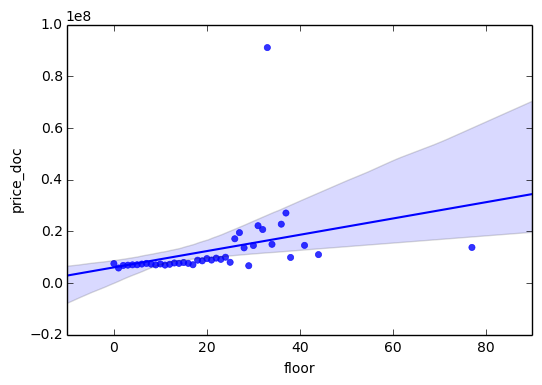

In [316]:
x = train.groupby(['floor'],as_index=False)['price_doc'].mean()
sns.regplot(x.floor,x.price_doc)

In [318]:
#checking if floor is bigger than max_floor
len(train[train['floor']>train['max_floor']])

1491

## Demographic Characteristics

In [327]:
cols = ['area_m', 'raion_popul', 'full_all', 'male_f', 'female_f', 'young_all', 
               'young_female', 'work_all', 'work_male', 'work_female', "sub_area",'price_doc']

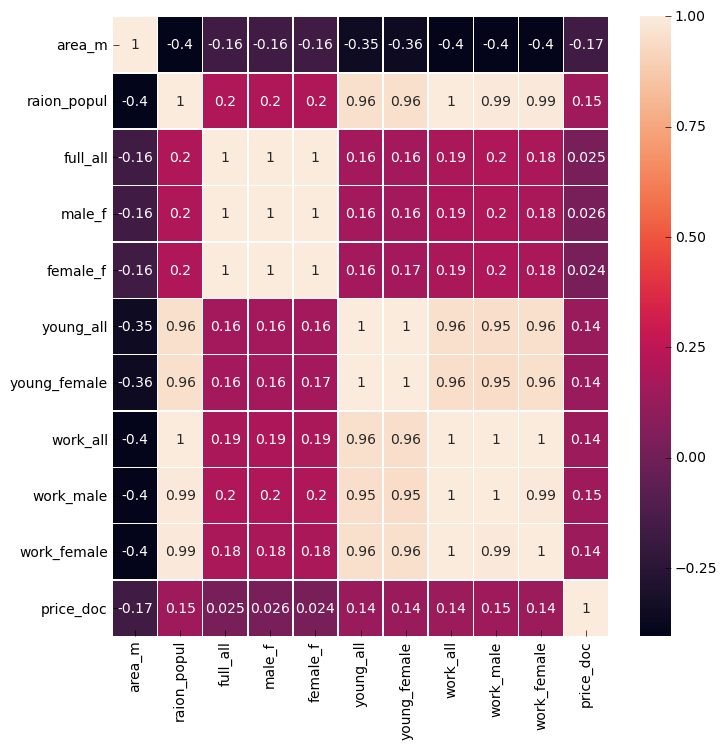

In [328]:
corr = train[cols].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr,annot=True,linewidths=0.1)

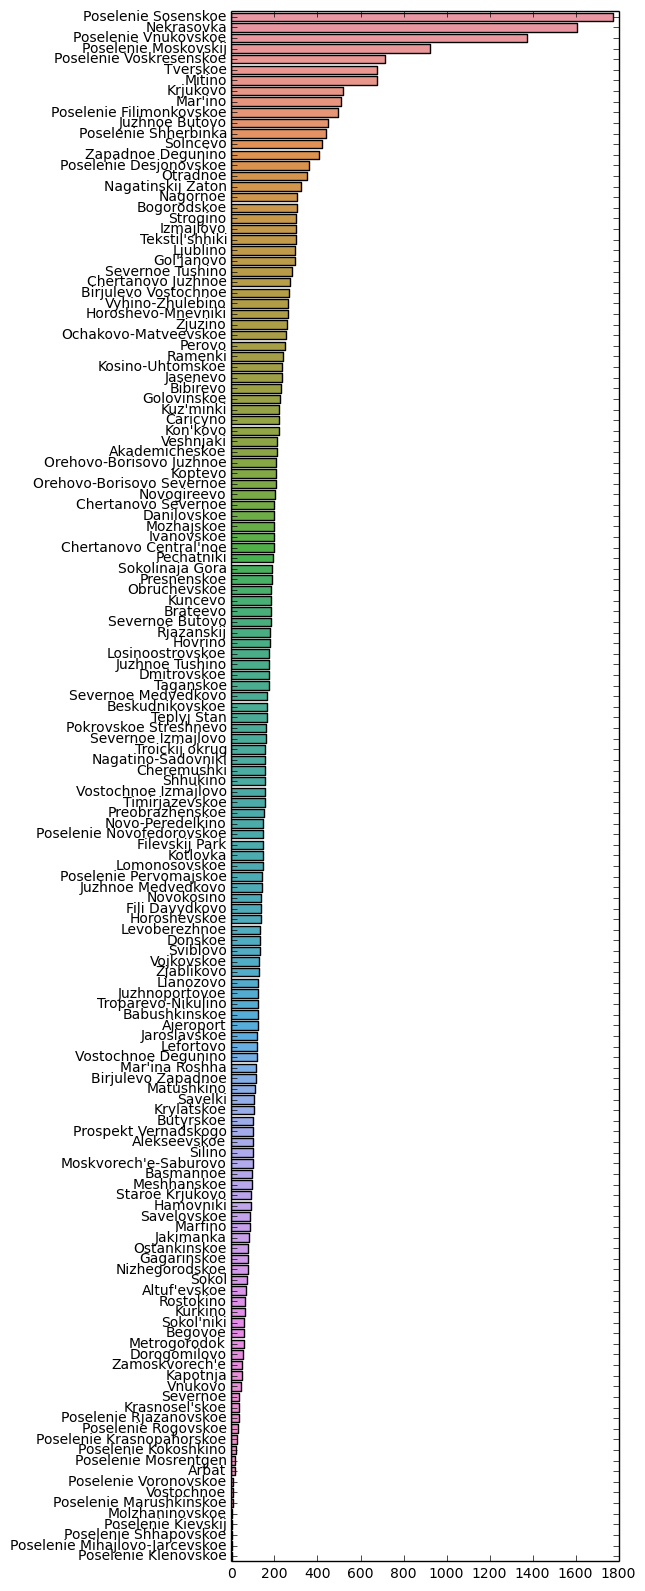

In [331]:
# transactions for each sub_area
x = train.sub_area.value_counts()
plt.figure(figsize=(5,20))
sns.barplot(x.values,x.index)

## School Characteristics

In [332]:
cols = ['children_preschool', 'preschool_quota', 'preschool_education_centers_raion',
                  'children_school', 'school_quota', 'school_education_centers_raion', 
                  'school_education_centers_top_20_raion', 'university_top_20_raion',
                  'additional_education_raion', 'additional_education_km', 'university_km',
                  'price_doc']

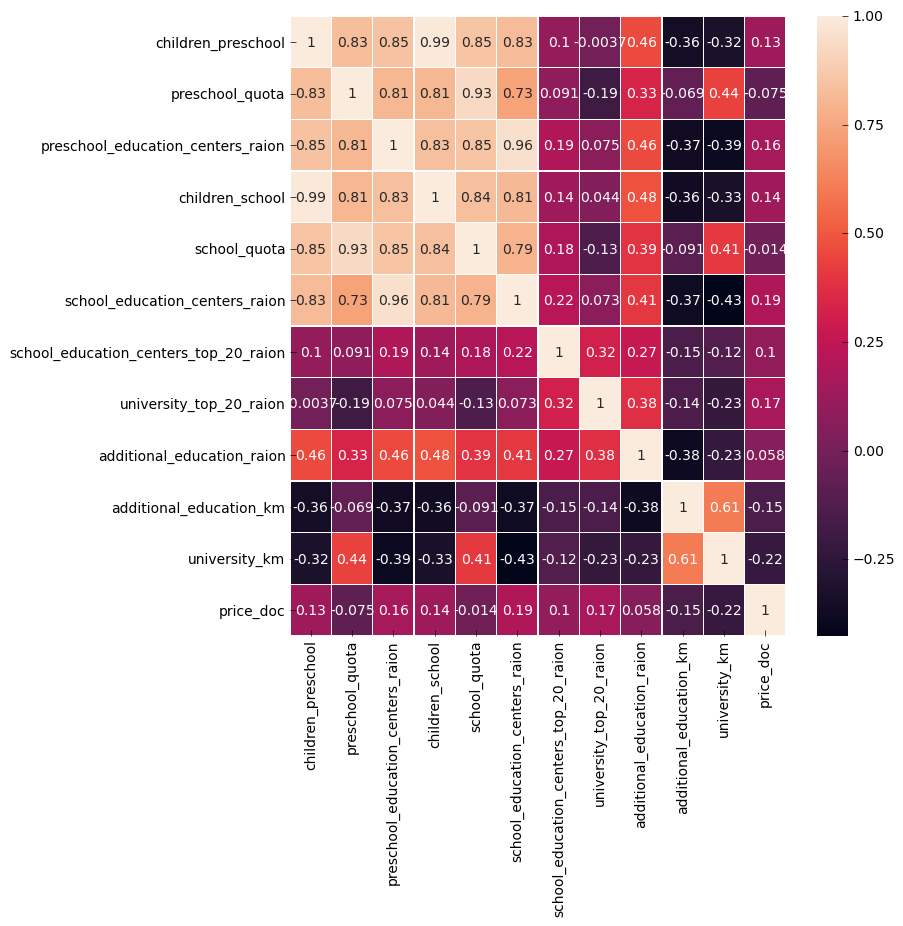

In [336]:
corr = train[cols].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr,annot=True,linewidths=0.1)

## Cultural/Recreational Characteristics

In [337]:
cols = ['sport_objects_raion', 'culture_objects_top_25_raion', 'shopping_centers_raion', 'park_km', 'fitness_km', 
        'swim_pool_km', 'ice_rink_km','stadium_km', 'basketball_km',                  
        'shopping_centers_km', 'big_church_km','church_synagogue_km', 'mosque_km', 'theater_km',
        'museum_km', 'exhibition_km', 'catering_km', 'price_doc']

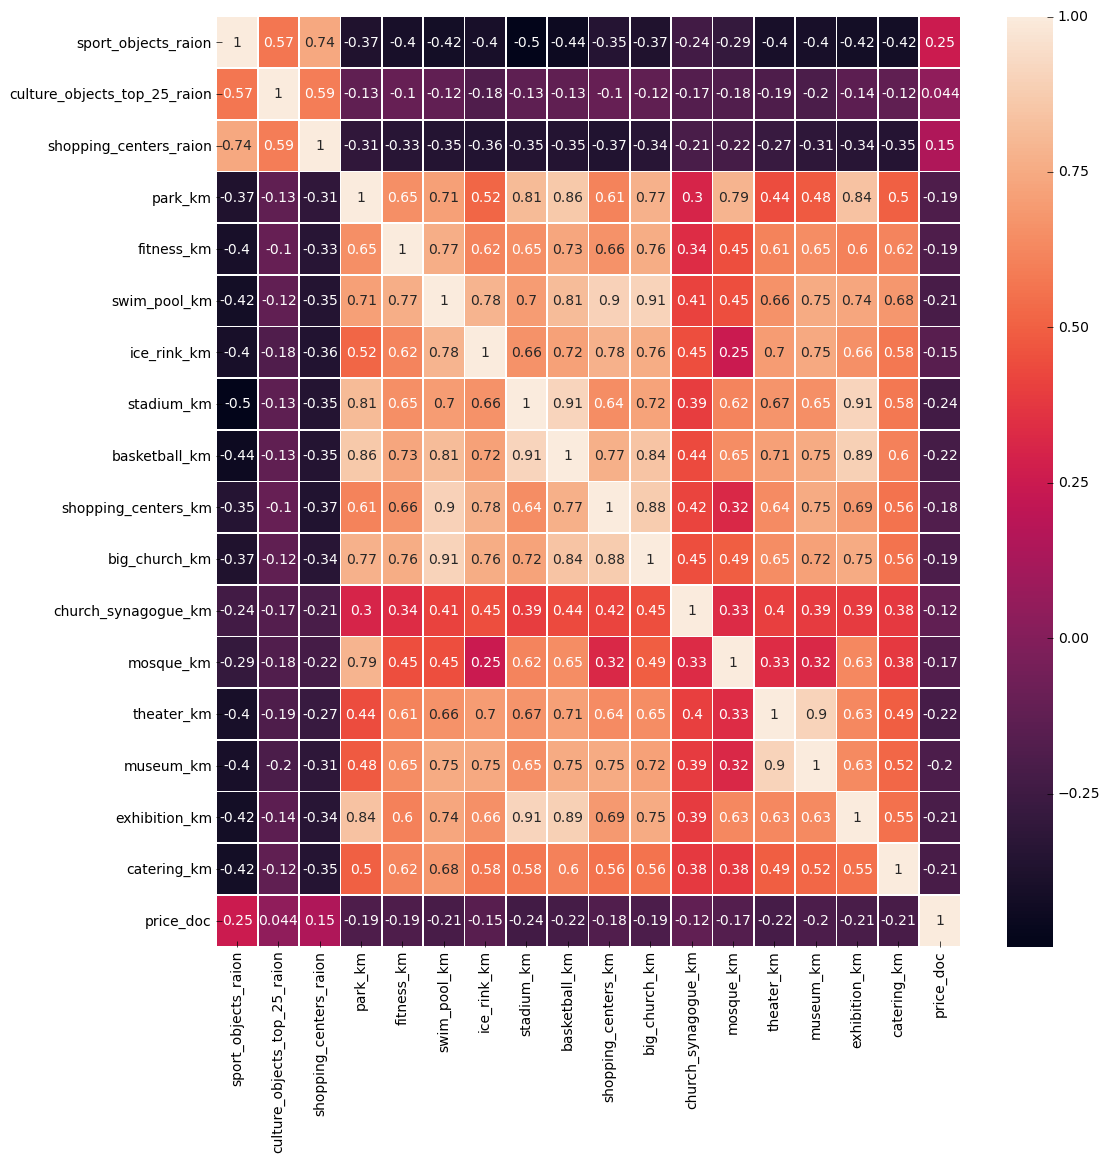

In [339]:
corr = train[cols].corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr,annot=True,linewidths=0.1)

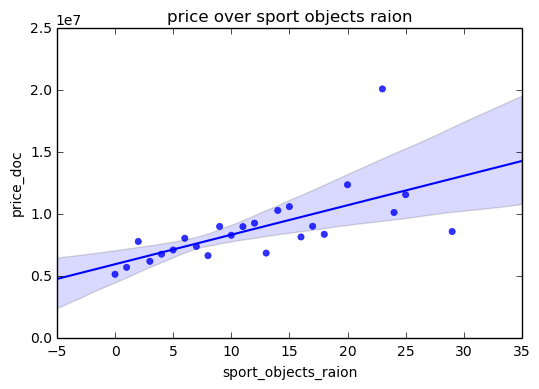

In [348]:
# look at sport_objects_raion

x = train.groupby(['sport_objects_raion'],as_index=False)['price_doc'].mean()
sns.regplot(x.sport_objects_raion,x.price_doc)
plt.title("price over sport objects raion")

## Infrastructure Features

In [349]:
cols = ['nuclear_reactor_km', 'thermal_power_plant_km', 'power_transmission_line_km',
                  'incineration_km','water_treatment_km', 'incineration_km', 'railroad_station_walk_km',                   'railroad_station_walk_min', 'railroad_station_avto_km', 'railroad_station_avto_min',                    'public_transport_station_km', 'public_transport_station_min_walk', 'water_km', 
        'mkad_km', 'ttk_km', 'sadovoe_km','bulvar_ring_km', 'kremlin_km', 'price_doc']

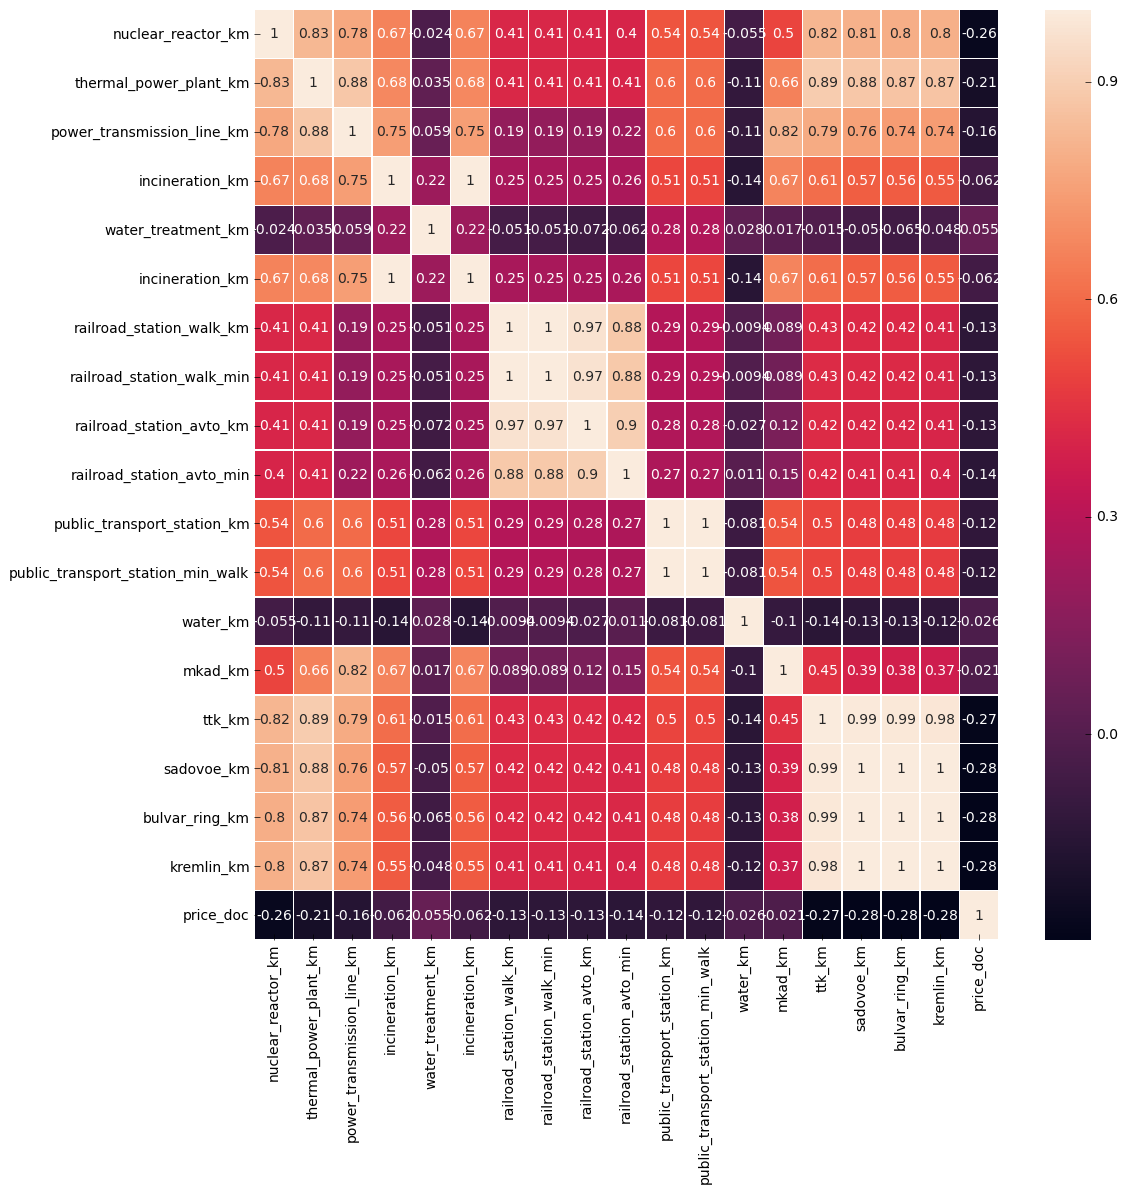

In [352]:
corr = train[cols].corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr,annot=True,linewidths=0.1)

## Variable Importance
Now I am going to run a quick random forest model on dtrain so that we can use the resulting variable importance values. In order to avoid having to impute missing data right now, I am going to subset dtrain to only include those observations that have values for every variable. This is about 6000 samples, or about 1/5th of the full data set. This should be a large enough sample just to get a rough idea of what variables have the most predictive power.

In [384]:
x = train.drop(['price_doc','timestamp','id'],axis=1)
y = train['price_doc']
y_mean = np.mean(y)

In [370]:
for c in train.select_dtypes(exclude=['int','float']).columns:
    lbl = LabelEncoder()
    lbl.fit(list(train[c].unique()))
    train[c] = lbl.transform(train[c])
    print c

timestamp
product_type
sub_area
culture_objects_top_25
thermal_power_plant_raion
incineration_raion
oil_chemistry_raion
radiation_raion
railroad_terminal_raion
big_market_raion
nuclear_reactor_raion
detention_facility_raion
water_1line
big_road1_1line
railroad_1line
ecology


In [375]:
train.fillna(-1,inplace=True)

In [376]:
xgb_params = {
    'silent':1,
    'eta':0.1,
    'max_depth':6,
    "subsample":0.8,
    'objective':"reg:linear",
    "eval_metric":"mae",
    "base_score":y_mean   
}
dtrain=xgb.DMatrix(x,y)
cvresults = xgb.cv(xgb_params,dtrain,num_boost_round=500,nfold=5,shuffle=True,show_stdv=False,early_stopping_rounds=50)
print cvresults

     test-mae-mean  test-mae-std  train-mae-mean  train-mae-std
0      2723273.400  35863.680193    2.719140e+06    7651.797703
1      2566882.850  35288.391137    2.559204e+06    7054.894033
2      2429377.500  32476.901793    2.416042e+06    7457.772443
3      2308202.800  30679.377303    2.289053e+06    6348.884706
4      2201524.000  30106.641480    2.175914e+06    6106.528780
5      2109306.075  29308.276873    2.076749e+06    4590.400336
6      2027811.575  28318.416814    1.990043e+06    4181.178299
7      1957467.850  27507.438010    1.912797e+06    4738.929524
8      1895801.050  26583.049511    1.844363e+06    4660.751465
9      1840853.275  25671.865001    1.784229e+06    5252.190097
10     1791999.600  24801.967847    1.729071e+06    6625.383894
11     1750291.975  24260.312492    1.681841e+06    6618.245512
12     1713170.950  24396.297510    1.640174e+06    6982.041868
13     1682151.625  23978.600185    1.603047e+06    7451.523268
14     1653147.375  22599.538567    1.56

In [388]:
print( "\nTraining XGBoost ...")
model = xgb.XGBRegressor( learning_rate =0.1, n_estimators=cvresults.shape[0], max_depth=6, 
                                    subsample=0.8, objective= "reg:linear")
model.fit(x,y)
feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
#feat_imp.plot(kind='bar', title='Feature Importances')
#plt.ylabel('Feature Importance Score')


Training XGBoost ...


In [395]:
top_20 = x.iloc[:,feat_imp.index[:20]].columns.values

In [397]:
top_20

array(['full_sq', 'floor', 'life_sq', 'day', 'max_floor', 'month',
       'build_year', 'kindergarten_km', 'kitch_sq', 'year',
       'public_transport_station_km', 'school_km', 'metro_min_avto',
       'public_healthcare_km', 'green_zone_km', 'num_room', 'state',
       'industrial_km', 'railroad_km', 'cemetery_km'], dtype=object)

In [400]:
len(feat_imp)

292